# 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import jpype
from konlpy.tag import Okt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 데이터 로드 및 탐색

In [2]:
spam_file_path = 'spam_data.csv'  # 스팸 메시지 CSV 파일 경로
normal_file_path = 'message_data.csv'  # 정상 메시지 CSV 파일 경로

spam_df = pd.read_csv(spam_file_path)
normal_df = pd.read_csv(normal_file_path)

df = pd.concat([spam_df, normal_df], ignore_index=True)

print(df.head())
print(df.info())
print(df.describe())

   label                                               data
0      0  아현이가 드리는 5장♥받으시고 대박나세요5장 출발 600출 도전!!쿄/드 6 3 7...
1      0  (광고)“「국민」는 더 나은 행복과 희망를 당신에게 선서 할수 있는 보다따뜻한 금융...
2      0  (광고)“「국민」는 당신이 힘들었던 만큼새해엔 더욱 빛나길 바라겠습니다.”새해도 국...
3      0  (광고)“「국민」는 더 나은 행복과 희망를 당신에게 선서 할수 있는 보다따뜻한 금융...
4      0  (광고)“「국민」는 더 나은 행복과 희망를 당신에게 선서 할수 있는 보다따뜻한 금융...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18560 entries, 0 to 18559
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   18560 non-null  int64 
 1   data    18560 non-null  object
dtypes: int64(1), object(1)
memory usage: 290.1+ KB
None
              label
count  18560.000000
mean       0.538793
std        0.498506
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000


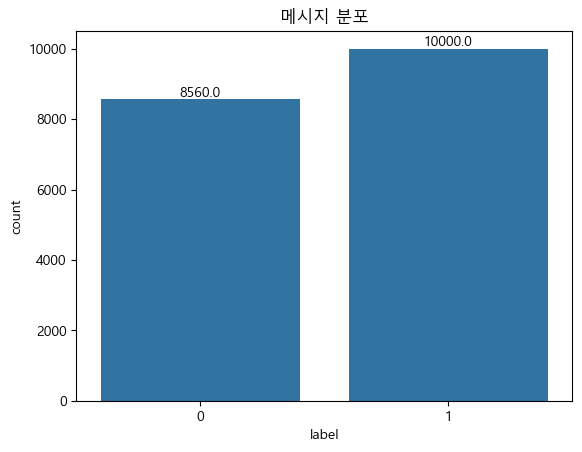

In [3]:
# 스팸 메시지와 정상 메시지 개수 그래프

## 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

ax = sns.countplot(x='label', data=df)
plt.title('메시지 분포')

# 막대 위에 수치 표시
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')

# 텍스트 전처리

In [4]:
# 소문자 변환
df['data'] = df['data'].str.lower()

# 특수문자 제거
df['data'] = df['data'].str.replace('[^\w\s]', '')

# 토큰화
okt = Okt()
def tokenize(text):
    return okt.morphs(text)

df['tokens'] = df['data'].apply(tokenize)

# 불용어 제거
korean_stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
def remove_stopwords(tokens):
    return [word for word in tokens if word not in korean_stopwords]

df['tokens'] = df['tokens'].apply(remove_stopwords)

# 재결합
df['processed_text'] = df['tokens'].apply(lambda x: ' '.join(x))

# 특징 추출

In [5]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['processed_text'])

# 데이터 분할 및 학습

In [6]:
# 데이터 분할: 60% 훈련, 20% 검증, 20% 테스트
y = df['label']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4)  # 60% 훈련, 40% 임시
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)  # 20% 검증, 20% 테스트

# 모델 선택 및 학습
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

# 스팸 메시지와 정상 메시지 분류 평가

In [7]:
# 검증 세트 평가
y_val_pred = model.predict(X_val)
print("Validation Set Evaluation:")
print(classification_report(y_val, y_val_pred))
print(confusion_matrix(y_val, y_val_pred))

# 테스트 세트 평가
y_test_pred = model.predict(X_test)
print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

Validation Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1685
           1       1.00      1.00      1.00      2027

    accuracy                           1.00      3712
   macro avg       1.00      1.00      1.00      3712
weighted avg       1.00      1.00      1.00      3712

[[1678    7]
 [   3 2024]]
Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1679
           1       1.00      1.00      1.00      2033

    accuracy                           1.00      3712
   macro avg       1.00      1.00      1.00      3712
weighted avg       1.00      1.00      1.00      3712

[[1673    6]
 [   9 2024]]


# 스팸 메시지 카테고리

In [8]:
from sklearn.cluster import KMeans

# 스팸 메시지만 추출 (복사본 생성)
spam_data = df[df['label'] == 0].copy()  # 복사본을 만들어 경고 방지
spam_X = vectorizer.transform(spam_data['processed_text'])

# K-Means 클러스터링
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(spam_X)

# 카테고리 할당
spam_data.loc[:, 'category'] = kmeans.labels_  # .loc[] 사용하여 카테고리 할당

# 각 클러스터의 중심 단어 추출
def get_top_keywords(model, vectorizer, n_terms=10):
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    keywords = {}
    for i in range(num_clusters):
        keywords[i] = [terms[ind] for ind in order_centroids[i, :n_terms]]
    return keywords

# 중심 단어 기반 카테고리 정의
keywords = get_top_keywords(kmeans, vectorizer)
category_mapping = {
    0: "광고", 1: "도박", 2: "통신", 3: "피싱", 4: "상품권",
    5: "금융", 6: "사기", 7: "프로모션", 8: "예약", 9: "기타"
}

# 카테고리 매핑 적용
spam_data.loc[:, 'category_name'] = spam_data['category'].map(category_mapping)  # .loc[] 사용

# 카테고리별 메시지 보기
for i in range(num_clusters):
    print(f"--- 카테고리: {category_mapping[i]} ---")
    print(spam_data[spam_data['category'] == i]['data'].head())


--- 카테고리: 광고 ---
744     (광고)복권구매할 돈으로점심25분간 135 000hxxps://bit.ly/3vfo...
745     (광고)복권구매할 돈으로점심25분간 135 000hxxps://bit.ly/3vfo...
1087    (광고)소정님께서band로 초청합니다hxxps://abit.ly/e5jbuv무료거부...
1088    (광고)소정님께서band로 초청합니다hxxps://abit.ly/e5jbuv무료거부...
1117    (광고)소정님의band로hxxps://abit.ly/vwmxxz초청합니다무료거부:*...
Name: data, dtype: object
--- 카테고리: 도박 ---
1589    (광고)[nh농협]특례지원 승인 안내고객님께서는『정부자금 지원대출』승인 대상자로 선...
1592    (광고)[nh농협]특례지원 승인 안내고객님께서는『정부자금 지원대출』승인 대상자로 선...
1593    (광고)[nh농협]특례지원 승인 안내고객님께서는『정부자금 지원대출』승인 대상자로 선...
1594    (광고)[nh농협]특례지원 승인 안내고객님께서는『정부자금 지원대출』승인 대상자로 선...
1596    (광고)[nh농협]특례지원 승인 안내고객님께서는『정부자금 지원대출』승인 대상자로 선...
Name: data, dtype: object
--- 카테고리: 통신 ---
6526    [skt] 추석 명절에 앞서 코로나19 정부지원 대출  택배 배송조회 등을 빙자한 ...
6527    [skt] 추석 명절에 앞서 코로나19 정부지원 대출  택배 배송조회 등을 빙자한 ...
6528    [skt] 추석 명절에 앞서 코로나19 정부지원 대출  택배 배송조회 등을 빙자한 ...
6529    [skt] 추석 명절에 앞서 코로나19 정부지원 대출  택배 배송조회 등을 빙자한 ...
6530    [skt] 추석 명절에 앞서 코로나19 정부지원 대출  택배 배송조회 등을 빙자한 ...
Name: data, dtype: object
-

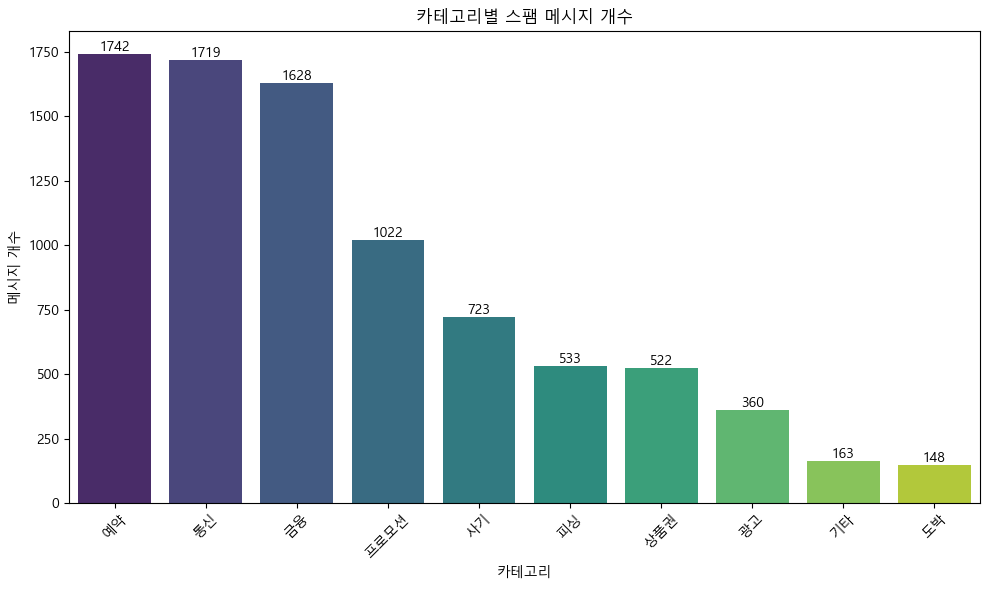

In [9]:
# 각 카테고리별 메시지 개수 계산
category_counts = spam_data['category_name'].value_counts()

# 카테고리별 메시지 개수 그래프
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis', hue=category_counts.index, legend=False)
plt.title('카테고리별 스팸 메시지 개수')
plt.xlabel('카테고리')
plt.ylabel('메시지 개수')
plt.xticks(rotation=45)
plt.tight_layout()

# 그래프에 수치 표시
for index, value in enumerate(category_counts.values):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

# 스팸 메시지 카테고리 분류 평가

Silhouette Score: 0.3352464759647545
Davies-Bouldin Index: 3.0082531921081497


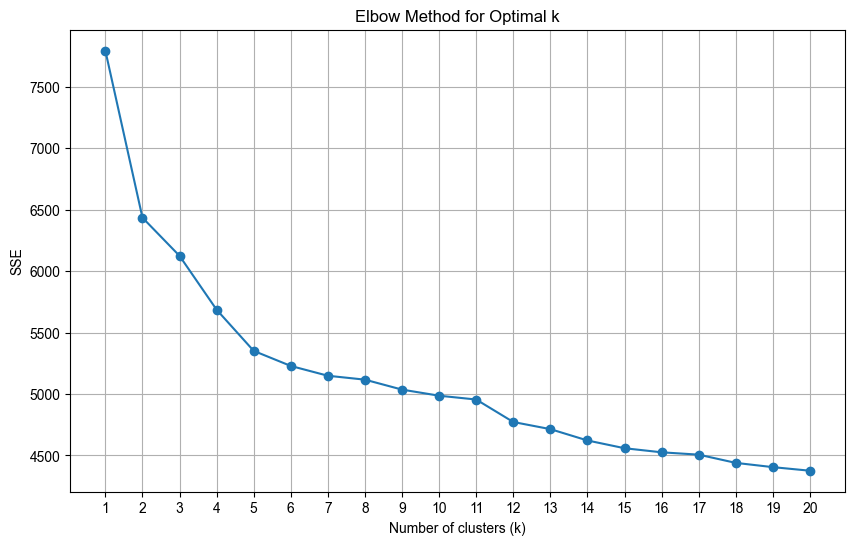

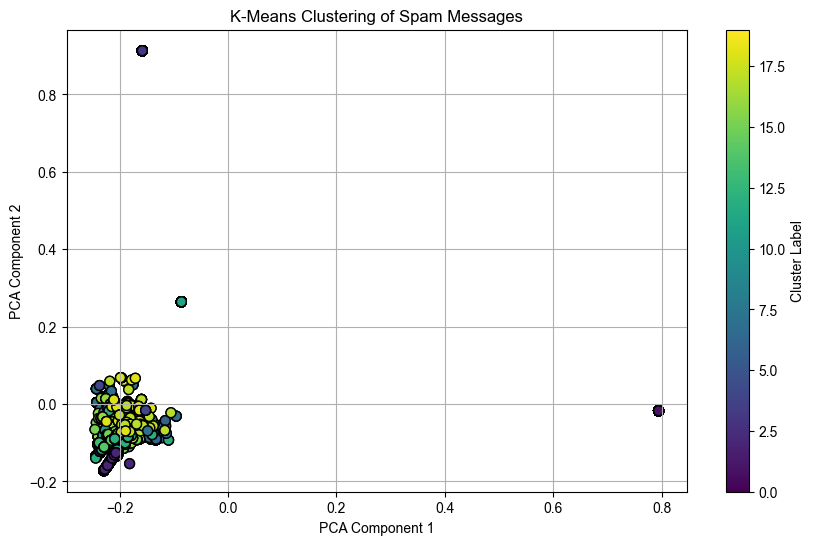

In [10]:
# 폰트 설정
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.sans-serif'] = ['Arial']

# 1. 실루엣 점수 계산
silhouette_avg = silhouette_score(spam_X, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

# 2. Davies-Bouldin Index 계산
db_index = davies_bouldin_score(spam_X.toarray(), kmeans.labels_)
print(f"Davies-Bouldin Index: {db_index}")

# 3. Elbow Method를 위한 SSE 계산
sse = []
k_range = range(1, 21)  # 클러스터 수를 1부터 20까지 변화시킴
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(spam_X)
    sse.append(kmeans.inertia_)

# Elbow Method 시각화
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.xticks(k_range)
plt.grid()
plt.show()

# 4. 클러스터링 결과 시각화 (2D)
pca = PCA(n_components=2)
spam_X_pca = pca.fit_transform(spam_X.toarray())

plt.figure(figsize=(10, 6))
plt.scatter(spam_X_pca[:, 0], spam_X_pca[:, 1], c=kmeans.labels_, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('K-Means Clustering of Spam Messages')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.grid()
plt.show()